# Diabetic Retinopathy Inception-v3

**Downloading data**

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "harshbandhey"
os.environ['KAGGLE_KEY'] = "82252853dfb7f0c3669b01c956eb85c3"

In [3]:
!rm -rf sample_data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [6]:
!pwd

/content/drive/My Drive/Kaggle


In [7]:
# !kaggle competitions download -c diabetic-retinopathy-detection

In [8]:
# for i in *zip; do 7z x "$i" & done

In [9]:
# !ls

In [10]:
# !7z x train.zip.001 -aos

In [11]:
# fl = os.listdir('train/')

In [12]:
# len(fl)

**Importing the required libraries**

In [13]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [14]:
import os
import gc
import numpy as np
import pandas as pd
import glob
import psutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
from sklearn.model_selection import train_test_split
from tensorflow import set_random_seed
import tensorflow as tf
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model,Sequential
from keras.layers import BatchNormalization
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input
from keras import backend as K

Using TensorFlow backend.


**Declaring the constansts**

In [15]:
SEED = 4199
np.random.seed(SEED)
set_random_seed(SEED)
dir_path = "/content/drive/My Drive/Kaggle/"
IMG_DIM = 299  # 224
BATCH_SIZE = 32
CHANNEL_SIZE = 3
NUM_EPOCHS = 20
TRAIN_DIR = 'train'
TEST_DIR = 'train'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
CLASSA = {0: "No DR", 1: "DR"}
NUM_CLASSS = 5
NUM_CLASSA = 2

In [16]:
ROOT_PATH = '/content/drive/My Drive/Kaggle'
TRAIN_PATH = '/content/drive/My Drive/Kaggle/' + TRAIN_DIR 
TEST_PATH = '/content/drive/My Drive/Kaggle/' + TEST_DIR 
dir_path = ROOT_PATH + '/'

**Loading the dataframes**

In [17]:
# print names of train images
train_img_names = glob.glob(TRAIN_PATH + '/*.jpeg')
#print(train_img_names)

In [18]:
df_train = pd.read_csv(ROOT_PATH + '/trainLabels.csv',header=0,names=['id_code','diagnosis'])
#print(df_train)

In [19]:
df_train.head()

,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [20]:
# Function to show one image

def draw_img(imgs, target_dir, class_label='0'):
    for row in enumerate(imgs.iterrows()):
        name = row[1][1]['id_code'] + '.jpeg'
        print(name)
        plt.figure(figsize=(3,2))
        img = plt.imread(dir_path + target_dir + '/' + name)
        plt.imshow(img)
        plt.title(class_label)
        plt.show()
        del img
        gc.collect()

**Showing randomly chosen No-DR image one at a time** 

40707_left.jpeg


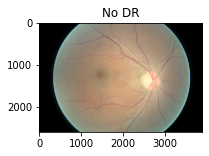

In [21]:
# Showing the class 0 image randomly
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train', CLASSS[CLASS_ID])

**Showing randomly chosen Mild DR image one at a time** 

8006_left.jpeg


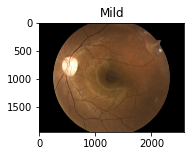

In [22]:
# Showing the class 1 image randomly
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train', CLASSS[CLASS_ID])

**Showing randomly chosen Moderate DR image one at a time** 

26630_right.jpeg


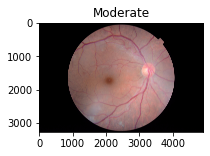

In [23]:
# Showing the class 2 image randomly
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train', CLASSS[CLASS_ID])

**Showing randomly chosen Severe DR image one at a time** 

40341_right.jpeg


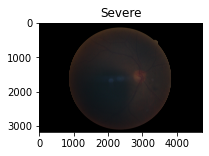

In [24]:
# Showing the class 3 image randomly
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train', CLASSS[CLASS_ID])

**Showing randomly chosen Proliferative DR image one at a time** 

28948_right.jpeg


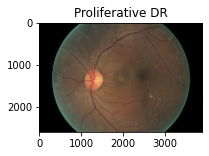

In [25]:
# Showing the class 4 image randomly
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train', CLASSS[CLASS_ID])

In [26]:
gc.collect()

0

**Split the train data into train and test(validation) set**

In [27]:
# !pip install -U imbalanced-learn

In [28]:
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
undersample = RandomUnderSampler(sampling_strategy={0: 2000, 1: 500, 2: 500, 3:500, 4:500})
# fit and apply the transform
X_over, y_over = undersample.fit_resample(df_train, df_train.diagnosis)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [30]:
dft = pd.DataFrame(X_over,columns=['id_code','diagnosis'])

In [31]:
dft.head()

,id_code,diagnosis
0,24727_right,0
1,22422_right,0
2,24144_right,0
3,25167_right,0
4,2500_left,0


In [32]:
# Split Dataset

y = dft[['diagnosis']]
X = dft

X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, random_state=SEED, test_size=0.4)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, random_state=SEED, stratify=y_test, test_size=0.5)


In [33]:
df_strain = pd.DataFrame(X_train,columns=['id_code','diagnosis'])
# df_strain = df_strain.replace([1,2,3,4],1)

In [34]:
df_sval = pd.DataFrame(X_val,columns=['id_code','diagnosis'])
# df_sval = df_sval.replace([1,2,3,4],1)

In [35]:
df_stest = pd.DataFrame(X_test,columns=['id_code','diagnosis'])
# df_stest = df_stest.replace([1,2,3,4],1)

In [36]:
df_sval.groupby('diagnosis').count()

,id_code
diagnosis,
0,400
1,100
2,100
3,100
4,100


**Obervations:**
The differences between the classes are very minute and intricate in *some cases*, which is difficult to detect by human eyes. So to capture the intricacies we can consider using Inception Network as it combines the information from different scales of the image and the 1x1 convolution helps to detect the complex functions as well as it helps to reduce dimension.

I have taken help from the following link for the inception module architecture:
https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b

**Defining the inception network**

In [51]:
input_tensor = Input(shape = (299, 299, 3))

# create the base pre-trained model
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=input_tensor)
#base_model.load_weights('/content/drive/My Drive/Kaggle/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# add a global spatial average pooling layer
x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(NUM_CLASSS, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers

for layer in model.layers:
    layer.trainable = True

for layer in base_model.layers:
    layer.trainable = False

    
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

In [38]:
# [layer.trainable for layer in model.layers]

In [39]:
# tf_model = tf.keras.models.Model(model)

In [40]:
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tf.logging.set_verbosity(tf.logging.INFO)

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     tf_model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)))

In [41]:
# model = tpu_model

In [52]:
epochs = 20
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=lrate)
# momentum = tf.train.MomentumOptimizer(learning_rate=lrate, momentum=0.9, use_nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

**Image Data Generator**: with Image Data Generator we can use Model.fit_generator() instead of Model.fit(). The 1st one exploits multiprocessing in python, while the 2nd one does not.

In [43]:
print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())

df_strain.id_code = df_train.id_code.apply(lambda x: x + ".jpeg")
df_sval.id_code = df_sval.id_code.apply(lambda x: x + ".jpeg")
df_stest.id_code = df_stest.id_code.apply(lambda x: x + ".jpeg")
df_strain['diagnosis'] = df_strain['diagnosis'].astype('str')
df_sval['diagnosis'] = df_sval['diagnosis'].astype('str')
df_stest['diagnosis'] = df_stest['diagnosis'].astype('str')

available RAM: svmem(total=13653602304, available=11893874688, percent=12.9, used=1708216320, free=875851776, active=3182981120, inactive=9132740608, buffers=50855936, cached=11018678272, shared=143593472, slab=202166272)
available RAM: svmem(total=13653602304, available=11893907456, percent=12.9, used=1708183552, free=875884544, active=3182993408, inactive=9132740608, buffers=50855936, cached=11018678272, shared=143593472, slab=202166272)


In [44]:
df_sval.head()

,id_code,diagnosis
3710,7992_left.jpeg,4
3023,30925_right.jpeg,3
3147,39322_right.jpeg,3
2003,8794_left.jpeg,1
2737,31183_left.jpeg,2


In [45]:
# Data Generator
train_datagen = image.ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)
# Data Generator
test_datagen = image.ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)
# Data Generator
val_datagen = image.ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)

In [46]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_strain,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    shuffle=True,
                                                    seed=SEED
                                                    )
valid_generator = val_datagen.flow_from_dataframe(dataframe=df_sval,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    shuffle=True,
                                                    seed=SEED
                                                    )
#del x_train
# # del x_test
#del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",

Found 2400 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


12

In [47]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(75, 25)

**keras Callbacks:**
Defining callback for EarlyStopping of training if the result is not significantly improving through some mentioned number of epochs. Defining callback for Reducnig learning rate on Platau regions of the underlying cost function.

In [48]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)
filepath = "/content/drive/My Drive/Kaggle/ckpt/incep_corr_epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [49]:
!nvidia-smi

Sat Dec 19 19:33:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    481MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     shuffle=True,  
                                     callbacks=[eraly_stop,reduce_lr,checkpoint],
                                     verbose=1)
gc.collect()

Epoch 1/20
45/75 [=================>............] - ETA: 3:30 - loss: 1.4431 - accuracy: 0.4903

In [ ]:
model.save('/content/drive/My Drive/Kaggle/inception_model_final')

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=valid_generator, steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

In [ ]:
'''scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))'''

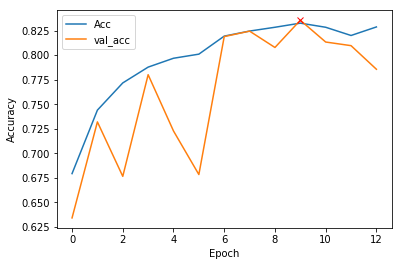

In [ ]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

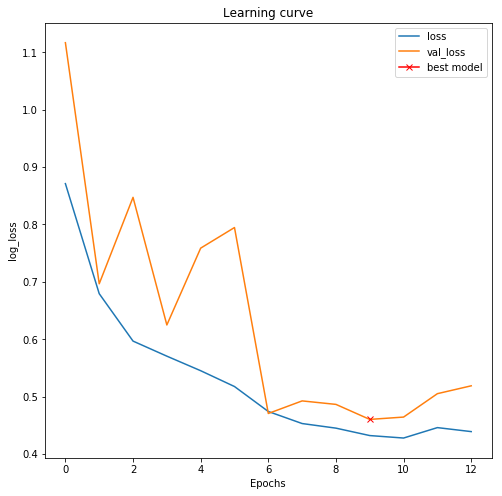

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory= TEST_PATH  + '/',
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

Found 1928 validated image filenames.
1928


5718

In [ ]:
# evaluating the model on test data

tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model.predict_generator(generator=test_generator, steps=ceil(df_test.shape[0]))
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))

100%|██████████| 5/5 [06:21<00:00, 76.42s/it]


In [ ]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

In [ ]:
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": predicted_class_indices})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("result.csv", index=False)